In [21]:
import configparser #install as  ConfigParser
import pandas as pd
import pandas_profiling as ppf
import numpy as np
import dropbox
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
config = configparser.ConfigParser()
config.read("C:/Users/Rohan/Desktop/Columbia/IEOR 4523 - Data Analytics/Project/desal_configuration.txt")
auth_token = config.get("configuration","auth_token")

In [3]:
#input file names and path to navigate through dropbox
solar_name = 'solar_desaldata v4.0.csv'
dbx_path = '/Group Project - Solar Desal/Datasets/1 - GWI'

In [4]:
dbx = dropbox.Dropbox(auth_token)
md, res = dbx.files_download(dbx_path+'/'+solar_name)

In [5]:
df = pd.read_csv(pd.compat.BytesIO(res.content),encoding = "ISO-8859-1")

C:\Users\Rohan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (23,24,38,48,50,52,61,63,65,67,80,85,87,89,93,95,96,98,100,106,111,116,127,128,129,130,133,134,135,138,139,140,143,144,145,153,159,160,174) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
pf = ppf.ProfileReport(df)

In [8]:
#After reviewing the ppf report and keeping features with at least 50% observation, then adding back features known to have high impact (such as prices), we ended with the following feature set:
# 'Award date','Capacity (m3/d)','Capacity (MGD)', 'Capital Cost per Unit of Daily Capacity ($/m3/d)','Country','Customer type','EPC contractor (desal)','EPC price','Feedwater','Holding Company',Inflation Adjusted EPC','Latitude','Location','Location','Location type','Location type','Longitude','Membrane type (RO)','Online date','Owner - Client','Plant status','Plant supplier','Plant supplier share','Plant type','Procurement model','Project name','Region','RO Feed Pump Drive','RO Membrane Type','RO System','Size','Subregion','Technology','Thermal design','Unit size (m3/d)','Units', 'Winner', 'Water price (USD/m3)'
mdf = df[['Award date','Capacity (m3/d)','Capacity (MGD)', 'Capital Cost per Unit of Daily Capacity ($/m3/d)','Country','Customer type','EPC contractor (desal)','EPC price','Feedwater','Holding Company','Inflation Adjusted EPC','Latitude','Location','Location','Location type','Location type','Longitude','Membrane type (RO)','Online date','Owner - Client','Plant status','Plant supplier','Plant supplier share','Plant type','Procurement model','Project name','Region','RO Feed Pump Drive','RO Membrane Type','RO System','Size','Subregion','Technology','Thermal design','Unit size (m3/d)','Units', 'Winner', 'Water price (USD/m3)']]

In [11]:
len(mdf)

18741

In [12]:
mdf = mdf[mdf['Inflation Adjusted EPC']>0]
len(mdf)

9728

In [19]:
minbound = mdf['Inflation Adjusted EPC'].quantile(q=0.05)
maxbound = mdf['Inflation Adjusted EPC'].quantile(q=0.95)
mdf = mdf[mdf['Inflation Adjusted EPC']<=maxbound]
mdf = mdf[mdf['Inflation Adjusted EPC']>=minbound]
len(mdf)

8748

In [20]:
8748/9728

0.8992598684210527

C:\Users\Rohan\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


<Figure size 2016x1296 with 0 Axes>

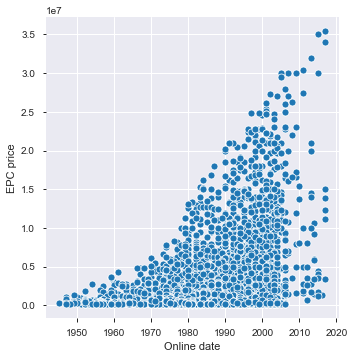

<Figure size 2016x1296 with 0 Axes>

In [41]:
ax = sns.pairplot(x_vars=["Online date"], y_vars=["EPC price"], data=mdf, size=5)
plt.figure(figsize=(28, 18))

C:\Users\Rohan\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


<Figure size 2016x1296 with 0 Axes>

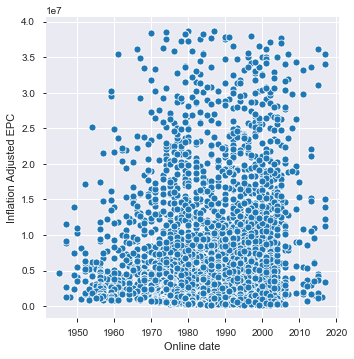

<Figure size 2016x1296 with 0 Axes>

In [42]:
sns.pairplot(x_vars=["Online date"], y_vars=["Inflation Adjusted EPC"], data=mdf, size=5)
plt.figure(figsize=(28, 18))

In [46]:
#will need to remove water as a factor since its mostly null 
mdf['Water price (USD/m3)'].dropna(inplace=False)

806      1.250
2641     1.030
2642     0.930
5003     0.298
9480     0.250
15092    0.870
15307    1.530
Name: Water price (USD/m3), dtype: float64

In [51]:
def getCountryPrices(cid):
    import requests
    from bs4 import BeautifulSoup
    url = "https://database.ib-net.org/country_profile?ctry="+str(cid)+"&years=2018,2017,2016,2015,2014,2013&type=report&ent=country&mult=true&table=true&chart=false&chartType=column&lang=en&exch=1"
    response = requests.get(url)
    soup = BeautifulSoup(response.content,'lxml')
    try:
        country_name = soup.find('li',class_='active').find('span').get_text().split('Country Profile ')[1]
    except:
        country_name = None
    #print(country_name)
    year = None
    cost = None
    if(country_name != None):
        for f in soup.find_all('script'):
            if (f.get('type') == 'text/javascript'):
                if(f.get('src') == None):
                    if('Costs, US$ per m3 sold' in f.get_text()):
                        years = list()
                        for x in f.get_text().split('xAxis')[1].split('[')[1].split(']')[0].split(','):
                            try:
                                years.append(int(x))
                            except:
                                years.append(0)
                                #print('--year error')
                        #years = [int(i) for i in (f.get_text().split('xAxis')[1].split('[')[1].split(']')[0].split(','))]
                        #print(years)
                        costs = list()
                        for x in f.get_text().split('Costs, US$ per m3 sold')[1].split('data')[1].split('[')[1].split(']')[0].split(','):
                            try:
                                costs.append(float(x))
                            except:
                                costs.append(0.0)
                                #print('--cost error')
                        #costs = [float(i) for i in f.get_text().split('Costs, US$ per m3 sold')[1].split('data')[1].split('[')[1].split(']')[0].split(',')]
                        #print(costs)
                        year = max(years)
                        cost = costs[len(costs)-1]
                        break
    return country_name, year, cost

In [52]:
waterPrices = {}
#cnt = 0
for i in range(300):
    #print(cnt)
    n,y,c = getCountryPrices(i)
    waterPrices[n] = {'year':y,'cost':c}
    #cnt += 1

In [74]:
def mapWater(x,feat):
    if(waterPrices.get(x) == None):
        return None
    else:
        if(feat == 'year'):
            return waterPrices.get(x)['year']
        else:
            return waterPrices.get(x)['cost']

In [75]:
mdf['Water Year'] = mdf['Country'].apply(lambda x:mapWater(x,'year'))
mdf['Water Cost'] = mdf['Country'].apply(lambda x:mapWater(x,'cost'))

In [77]:
mdf[mdf['Water Cost']>0]

,Award date,Capacity (m3/d),Capacity (MGD),Capital Cost per Unit of Daily Capacity ($/m3/d),Country,Customer type,EPC contractor (desal),EPC price,Feedwater,Holding Company,...,Size,Subregion,Technology,Thermal design,Unit size (m3/d),Units,Winner,Water price (USD/m3),Water Year,Water Cost
271,1995.0,"6,000",1.59,1528.4198,Argentina,Industry (TDS <10ppm),"Ionics, Inc.",5870000.0,Brackish water or inland water (TDS 3000ppm - ...,GdF Suez,...,M,Latin America / Caribbean,ED (Electrodialysis),NaN,2000.0,3.0,NaN,NaN,2014.0,0.056350
273,1989.0,"3,600",0.95,1849.392162,Argentina,Industry (TDS <10ppm),Christ Water Technology Group,3550000.0,Brackish water or inland water (TDS 3000ppm - ...,GLV,...,M,Latin America / Caribbean,RO (Reverse Osmosis),NaN,1800.0,2.0,NaN,NaN,2014.0,0.056350
277,2000.0,"2,600",0.69,1428.935942,Argentina,Industry (TDS <10ppm),Veolia Iberica (Bekox),2610000.0,Brackish water or inland water (TDS 3000ppm - ...,Veolia,...,M,Latin America / Caribbean,RO (Reverse Osmosis),NaN,1300.0,2.0,NaN,NaN,2014.0,0.056350
281,1990.0,"2,400",0.63,1312.285854,Argentina,Industry (TDS <10ppm),Christ Water Technology Group,1750000.0,Pure water or tap water (TDS <500ppm),GLV,...,M,Latin America / Caribbean,RO (Reverse Osmosis),NaN,800.0,3.0,NaN,NaN,2014.0,0.056350
291,2000.0,"1,636",0.43,1409.539712,Argentina,Municipalities as drinking water (TDS 10ppm - ...,"Ionics, Inc.",1620000.0,Brackish water or inland water (TDS 3000ppm - ...,GdF Suez,...,M,Latin America / Caribbean,ED (Electrodialysis),NaN,1636.0,1.0,NaN,NaN,2014.0,0.056350
296,1995.0,"1,440",0.38,1117.456271,Argentina,Industry (TDS <10ppm),Blanco,1030000.0,Pure water or tap water (TDS <500ppm),Blanco,...,M,Latin America / Caribbean,RO (Reverse Osmosis),NaN,1440.0,1.0,NaN,NaN,2014.0,0.056350
300,1996.0,"1,200",0.32,1539.954309,Argentina,Industry (TDS <10ppm),Degremont,1210000.0,Brackish water or inland water (TDS 3000ppm - ...,GdF Suez,...,M,Latin America / Caribbean,RO (Reverse Osmosis),NaN,1200.0,1.0,NaN,NaN,2014.0,0.056350
301,1996.0,"1,200",0.32,1539.954309,Argentina,Industry (TDS <10ppm),Degremont,1210000.0,Brackish water or inland water (TDS 3000ppm - ...,GdF Suez,...,M,Latin America / Caribbean,RO (Reverse Osmosis),NaN,1200.0,1.0,NaN,NaN,2014.0,0.056350
302,1994.0,"1,200",0.32,1336.968061,Argentina,Industry (TDS <10ppm),Blanco,970000.0,River water or low concentrated saline water (...,Blanco,...,M,Latin America / Caribbean,RO (Reverse Osmosis),NaN,1200.0,1.0,NaN,NaN,2014.0,0.056350
315,1970.0,768,0.20,6304.526749,Argentina,Power stations (TDS <10ppm),Ansaldo Energia,800000.0,Brackish water or inland water (TDS 3000ppm - ...,Ansaldo Energia,...,S,Latin America / Caribbean,MSF (Multi-stage Flash),Flash,384.0,2.0,NaN,NaN,2014.0,0.056350


In [89]:
infl_dict = {}
infl_set = df[['Inflation Multiple','Online date']].drop_duplicates(inplace=False)
for x in range(len(infl_set)):
    infl_dict[infl_set.iloc[x]['Online date']] = infl_set.iloc[x]['Inflation Multiple']

In [98]:
def infl_map(year):
    if(infl_dict.get(year) == None):
        return 0.0
    else:
        return infl_dict.get(year)

In [99]:
mdf['Water Inflation Multiple'] = mdf['Water Year'].apply(lambda x:infl_map(x))

In [115]:
mdf['Inflation Adjusted Water Cost'] = mdf.apply(lambda x:x['Water Year']*x['Water Inflation Multiple'],axis=1)

In [116]:
mdf['Inflation Adjusted Water Cost'].describe()

count    2460.000000
mean     1716.234312
std       899.185723
min         0.000000
25%      2017.000000
50%      2085.325764
75%      2259.470961
max      2600.426045
Name: Inflation Adjusted Water Cost, dtype: float64

In [123]:
water_countries = mdf[['Country','Inflation Adjusted EPC','Inflation Adjusted Water Cost']][mdf['Inflation Adjusted Water Cost']>0]['Country'].unique()
print(len(water_countries))
print(water_countries)

61
['Argentina' 'Australia' 'Azerbaijan' 'Bahrain' 'Belarus' 'Botswana'
 'Brazil' 'Bulgaria' 'Chile' 'China' 'Colombia' 'Costa Rica' 'Cyprus'
 'Czech Republic' 'Dominican Republic' 'Ecuador' 'Egypt' 'Fiji'
 'French Polynesia' 'Guam' 'Guinea' 'Honduras' 'Hungary' 'India'
 'Indonesia' 'Iraq' 'Jordan' 'Kazakhstan' 'Kenya' 'Kuwait' 'Malaysia'
 'Marshall Islands' 'Mauritania' 'Mauritius' 'Mexico' 'Namibia'
 'New Zealand' 'Nicaragua' 'Nigeria' 'Northern Mariana Islands' 'Norway'
 'Pakistan' 'Paraguay' 'Peru' 'Philippines' 'Poland' 'Portugal' 'Russia'
 'Senegal' 'Serbia' 'Singapore' 'South Africa' 'South Korea' 'Sudan'
 'Switzerland' 'Tunisia' 'Turkey' 'Ukraine' 'Uzbekistan' 'Vietnam' 'Yemen']


In [122]:
mdf.describe()

,Award date,Capacity (MGD),EPC price,Inflation Adjusted EPC,Latitude,Longitude,Online date,Plant supplier share,Unit size (m3/d),Units,Water price (USD/m3),Water Year,Water Cost,Water Inflation Multiple,Inflation Adjusted Water Cost
count,8747.000000,8747.000000,8.748000e+03,8.748000e+03,6824.000000,6824.000000,8748.000000,7836.000000,8678.000000,8678.000000,7.000000,2460.000000,2460.000000,8748.000000,2460.000000
mean,1987.890362,0.471598,1.982987e+06,3.970508e+06,29.306617,19.972564,1988.682556,98.991831,1076.938396,1.507029,0.879714,1585.152439,0.699618,0.239881,1716.234312
std,10.695908,1.026758,3.521968e+06,6.089483e+06,15.062197,80.028949,10.570388,7.183073,1953.808055,3.021895,0.469064,822.849914,0.920904,0.450905,899.185723
min,1944.000000,0.030000,8.000000e+04,2.214523e+05,-53.150000,-169.538012,1945.000000,0.000000,0.000000,1.000000,0.250000,0.000000,0.000000,0.000000,0.000000
25%,1981.000000,0.065000,3.000000e+05,6.662318e+05,24.866667,-64.670166,1982.000000,100.000000,220.000000,1.000000,0.584000,2004.000000,0.145686,0.000000,2017.000000
50%,1989.000000,0.150000,7.100000e+05,1.595051e+06,31.416667,33.982086,1990.000000,100.000000,490.000000,1.000000,0.930000,2010.000000,0.345246,0.000000,2085.325764
75%,1996.000000,0.410000,1.892500e+06,4.123369e+06,36.976860,60.000000,1997.000000,100.000000,1100.000000,1.000000,1.140000,2015.000000,0.935423,0.000000,2259.470961
max,2016.000000,15.850000,3.550000e+07,3.873155e+07,70.636944,177.100000,2017.000000,100.000000,48000.000000,160.000000,1.530000,2017.000000,7.994429,1.297618,2600.426045
